This first block of text simply contains all the libraries that need importing as well as initialising some variables of this example. You may change the batch_size and epochs variables, but should not change num_classes, img_rows and img_cols as these depend on the dataset being used

In [1]:
from __future__ import print_function
import tensorflow.keras as keras
import tensorflow.keras.datasets as datasets
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_sizes = [32, 64, 128, 256, 512]
num_classes = 10
epochs = 30

# input image dimensions
img_rows, img_cols = 32, 32

The next block of text handles all the data loading (in this case of the CIFAR-10 dataset) and reshaping so that it can be used to train and evaluate the CNN models. Two sets of data are loaded, the training data, used to generate the model, and the test data, used to evaluate if this model is good at making predictions

The final set of code of this cell defines the data augmentation pipeline

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test_orig = y_test
y_test = keras.utils.to_categorical(y_test, num_classes)

# Enable the data augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
datagen.fit(x_train)

170500096/170498071 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


This cell loads given pre-defined architecture, that had been trained for a different problem. It removes the last layer (because that would be specific to the original problem, and adds some new layers. This process of adapting a network trained on a different problem is called *Transfer Learning*.

The only essential new layer to add is the softmax one (last) that specifies the number of classes of the new dataset.

In [3]:
def get_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)

    # The rest of this cell is common to both defining the full architecture or using a pre-trained one
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adamax(),
                  metrics=['accuracy'])

    return model

This is the block of code that trains models and evaluates their predictive capacity on the test data.

In [4]:
# Enable Early Stopping to prevent model from overfitting
callback=keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    restore_best_weights=True)

results = []

for batch_size in batch_sizes:
    model = get_model()

    # Fits the model on batches with real-time data augmentation
    history = model.fit(datagen.flow(x_train, y_train,
             batch_size=batch_size),
             steps_per_epoch=len(x_train) / batch_size,
             epochs=epochs,
             callbacks=[callback],
             validation_data=(x_test, y_test),
             verbose=1)

    # Evaluate the model on the test data
    val_loss = min(history.history['val_loss'])
    epoch = history.history['val_loss'].index(val_loss)
    val_accuracy = history.history['val_accuracy'][epoch]

    # Append model results
    results.append([batch_size, '%.2f%%' % (val_accuracy * 100), '%.2f' % val_loss, epoch + 1])

    # Display the best accuracy and loss of the CNN architecture
    print('Batch size:', results[-1][0], ', Accuracy:', results[-1][1], ', Loss:', results[-1][2])
    print()

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/30
1562/1562 [==============================] - 140s 70ms/step - loss: 1.9177 - accuracy: 0.2579 - val_loss: 0.9654 - val_accuracy: 0.6637
Epoch 2/30
1562/1562 [==============================] - 108s 69ms/step - loss: 0.9504 - accuracy: 0.6738 - val_loss: 0.6402 - val_accuracy: 0.7857
Epoch 3/30
1562/1562 [==============================] - 107s 69ms/step - loss: 0.6920 - accuracy: 0.7711 - val_loss: 0.6224 - val_accuracy: 0.8012
Epoch 4/30
1562/1562 [==============================] - 107s 68ms/step - loss: 0.5724 - accuracy: 0.8113 - val_loss: 0.7588 - val_accuracy: 0.7787
Epoch 5/30
1562/1562 [==============================] - 106s 68ms/step - loss: 0.4982 - accuracy: 0.8352 - val_loss: 0.5092 - val_accuracy: 0.8334
Epoch 6/30
1562/1562 [==============================] - 106s 68ms/step - loss: 0.4365 - accuracy: 0.8555 - val_loss: 0.5192 - val_accuracy: 0.8390
Epoch 7/30
1562/1562 [==============================]

Finally, comparison table of models with different batch sizes

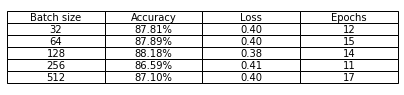

In [5]:
# Display table
plt.figure(figsize=(7,1.5))
plt.table(colLabels=['Batch size', 'Accuracy', 'Loss', 'Epochs'],
          cellText=results,
          cellLoc='center',
          loc='center')
plt.axis('off')
plt.savefig('Batch-sizes-comparison.jpg', bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()